# Experimentación - DryGrEncoder



## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"


In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_214
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_32
Processing:  row_57
Processing:  row_110
Processing:  row_248
Processing:  row_119
Processing: 

## Funciones auxiliares - entrenamiento

In [4]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import EvolveGCNO, EvolveGCNH
from utils.dygrae import DyGrEncoder
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot

from utils.trainer import TrainerModel
from utils import trainer
dtype = torch.float
device = torch.device("cpu")

In [5]:
def reconstruir_predictions(predictions,real, n_target, situacion, n_div, n_nodes=23):
    
    temp = np.array(predictions).reshape(-1, n_nodes, n_target)
    temp2 =np.array(real).reshape(-1, n_nodes, n_target)
    if n_div != None:
        id_situacion = situacion*n_div 
        return n_div, np.concatenate([np.array(temp[id_situacion+i]) for i in range(n_div)], axis=1), np.concatenate([np.array(temp2[id_situacion+i]) for i in range(n_div)], axis=1)
    m = temp.shape[0]
    return m, np.concatenate([np.array(temp[situacion+i]) for i in range(m)], axis=1), np.concatenate([np.array(temp2[situacion+i]) for i in range(m)], axis=1)


In [6]:
def plot_training_and_eval_losses(train_losses, eval_losses, num_epochs, format_plot):
    epochs = range(1, num_epochs + 1)


    plt.figure(figsize=(12, 5), dpi=200)
    ax = plt.gca()

    sns.lineplot(x=epochs, y=train_losses, label='Training Loss')
    sns.lineplot(x=epochs, y=eval_losses, label='Evaluation Loss', color="royalblue")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss by Epoch')
    ax.legend()
    format_plot(ax) 
    plt.tight_layout()
    plt.show()

In [7]:
def plot_predictions(predictions, real, n_target, n_situation, n_div, problem):
    # Reconstruct predictions and true values
    m, preds, y_true = reconstruir_predictions(predictions, real, n_target, n_situation, n_div=n_div)
    
    n_plots = 23
    n_cols = 4
    n_rows = (n_plots + n_cols - 1) // n_cols  # Calculating number of rows

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10), dpi=200)
    handles = []
    labels = []
    for i in range(n_plots):
        row = i // n_cols  # Calculate the row index
        col = i % n_cols   # Calculate the column index
        ax = axs[row, col]

        sns.lineplot(y=y_true[i], x=range(n_target * m), ax=ax, label='Real', legend=False, color="royalblue")
        sns.lineplot(y=preds[i], x=range(n_target * m), ax=ax, label='Predicciones', legend=False)
        if not handles:
            handles, labels = ax.get_legend_handles_labels()
        ax.set_title(f'Nodo {i+1}')
        format_plot(ax)
    
    # Add legend to the last plot
    #axs[n_rows - 1, n_cols - 2].legend(loc='upper right', bbox_to_anchor=(1.5, 0.95), frameon=True)
    fig.legend(handles, ['Real', 'Predicciones'], bbox_to_anchor=(0.95, 0.08),loc = 'lower right', fontsize=15)

    # Remove any unused subplots
    if n_plots < (n_rows * n_cols):
        for i in range(n_plots, (n_rows * n_cols)):
            fig.delaxes(axs.flatten()[i])

    # Adjust layout and add super title
    plt.suptitle(f'Predicciones y valores reales en {problem}, caso {n_situation}', fontsize=20)
    plt.tight_layout(pad=2)
    plt.show()

In [8]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, num_conv=1,  num_lstm=1, aggr="mean"):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        super(RecurrentGCN, self).__init__()
        self.recurrent = DyGrEncoder(conv_out_channels=100, conv_num_layers=num_conv, conv_aggr=aggr, lstm_out_channels=self.n_features, lstm_num_layers=num_lstm)
        self.linear = torch.nn.Linear(self.n_features, n_target)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h, h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h)
        h = self.linear(h)
        return h, h_0, c_0


In [9]:
def eval(model, dataloader, h):
    model.eval()
    loss_eval, r2_eval = [], []
    h, c = None, None
    for time, snapshot in enumerate(dataloader['val']):
        x = snapshot.x  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
        edge_attr = snapshot.edge_attr.permute(1, 0, 2)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
        y = snapshot.y

        y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
        loss = F.mse_loss(y_hat, y).item()
        r2_eval.append(r2_score(y.cpu(), y_hat.cpu()))
        loss_eval.append(loss)
    return loss_eval, r2_eval




def train(model,dataloader, num_early_stop, num_epochs, lr ):

    print("\n==================== TRAIN INFO ===================\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    lr_schedule = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.001)
    early_stop_counter = 0
    best_eval_r2score = -100.0
    best_eval_loss = float('inf')
    losses = []
    eval_losses, r2scores = [], []
    is_best = False

    for epoch in range(num_epochs):
        model.train()
        cost = 0
        h,c=None, None
        for time, snapshot in enumerate(dataloader['val']):
            x = snapshot.x  # [num_nodes, num_time_steps] -> [23, 100]
            edge_index = snapshot.edge_index.permute(2, 1, 0)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
            edge_attr = snapshot.edge_attr.permute(1, 0, 2)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
            y = snapshot.y

            y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
            cost = cost + F.mse_loss(y_hat, y)
        
        cost = cost / (time+1)
        cost.backward(retain_graph=False)
        losses.append(cost.item())
        optimizer.step()
        optimizer.zero_grad()
            
        train_loss = cost

    
        with torch.no_grad():
            e_loss_batch, r2_loss_batch = eval(model, dataloader, h)
            eval_loss = torch.FloatTensor(e_loss_batch).mean().item()
            eval_r2score = torch.FloatTensor(r2_loss_batch).mean().item()
            eval_losses.append(e_loss_batch)
            r2scores.append(r2_loss_batch)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | "
            f"Eval R2: {eval_r2score:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if num_early_stop > 0:
            if eval_loss <= best_eval_loss:
                best_eval_loss = eval_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
                print("Early stopping triggered.")
                break
            
        if lr_schedule:
            lr_schedule.step(eval_loss)

        if best_eval_r2score < eval_r2score:
            is_best = True
            best_eval_r2score = eval_r2score
        recording = {"epoch": epoch, "is_best": str(is_best)}
    print("\nTraining completed.")
    return losses, eval_losses, r2scores, h
    


def test(model, dataloader, h):
    
    print("\n==================== TEST INFO ===================\n")
    
    model.eval()
    predictions = []
    real =[]
    losses_tst, r2score_tst = [], []
    h,c=None, None
    for time, snapshot in enumerate(dataloader['val']):
        x = snapshot.x  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
        edge_attr = snapshot.edge_attr.permute(1, 0, 2)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
        y = snapshot.y

        y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
        loss = F.mse_loss(y_hat, y).item()


        preds = y_hat.view(model.n_nodes, model.n_target)
        real.append(y.view(model.n_nodes, model.n_target).cpu())
        predictions.append(preds.cpu().detach().numpy())
        r2score_tst.append(r2_score(y.detach().cpu(), y_hat.detach().cpu()))
        losses_tst.append(loss)
    test_loss = torch.tensor(losses_tst).mean().item()
    test_r2score = np.mean(r2score_tst)

    print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")
    return r2score_tst, losses_tst, predictions, real

## Prueba - predicción por tipos

### Gen trip

In [10]:
problem = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [11]:
n_div_gt = loader.div

#### Sencilla 

In [12]:
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0666 | Eval Loss: 0.5810 | Eval R2: -258.0969 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5810 | Eval Loss: 0.1258 | Eval R2: -40.4606 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1258 | Eval Loss: 0.1887 | Eval R2: -78.1078 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1887 | Eval Loss: 0.1261 | Eval R2: -45.0852 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1261 | Eval Loss: 0.0882 | Eval R2: -23.9042 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0882 | Eval Loss: 0.1057 | Eval R2: -31.2467 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1057 | Eval Loss: 0.1112 | Eval R2: -33.9093 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1112 | Eval Loss: 0.0925 | Eval R2: -25.4239 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0925 | Eval Loss: 0.0897 | Eval R2: -24.1517 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0897 | Eval Loss

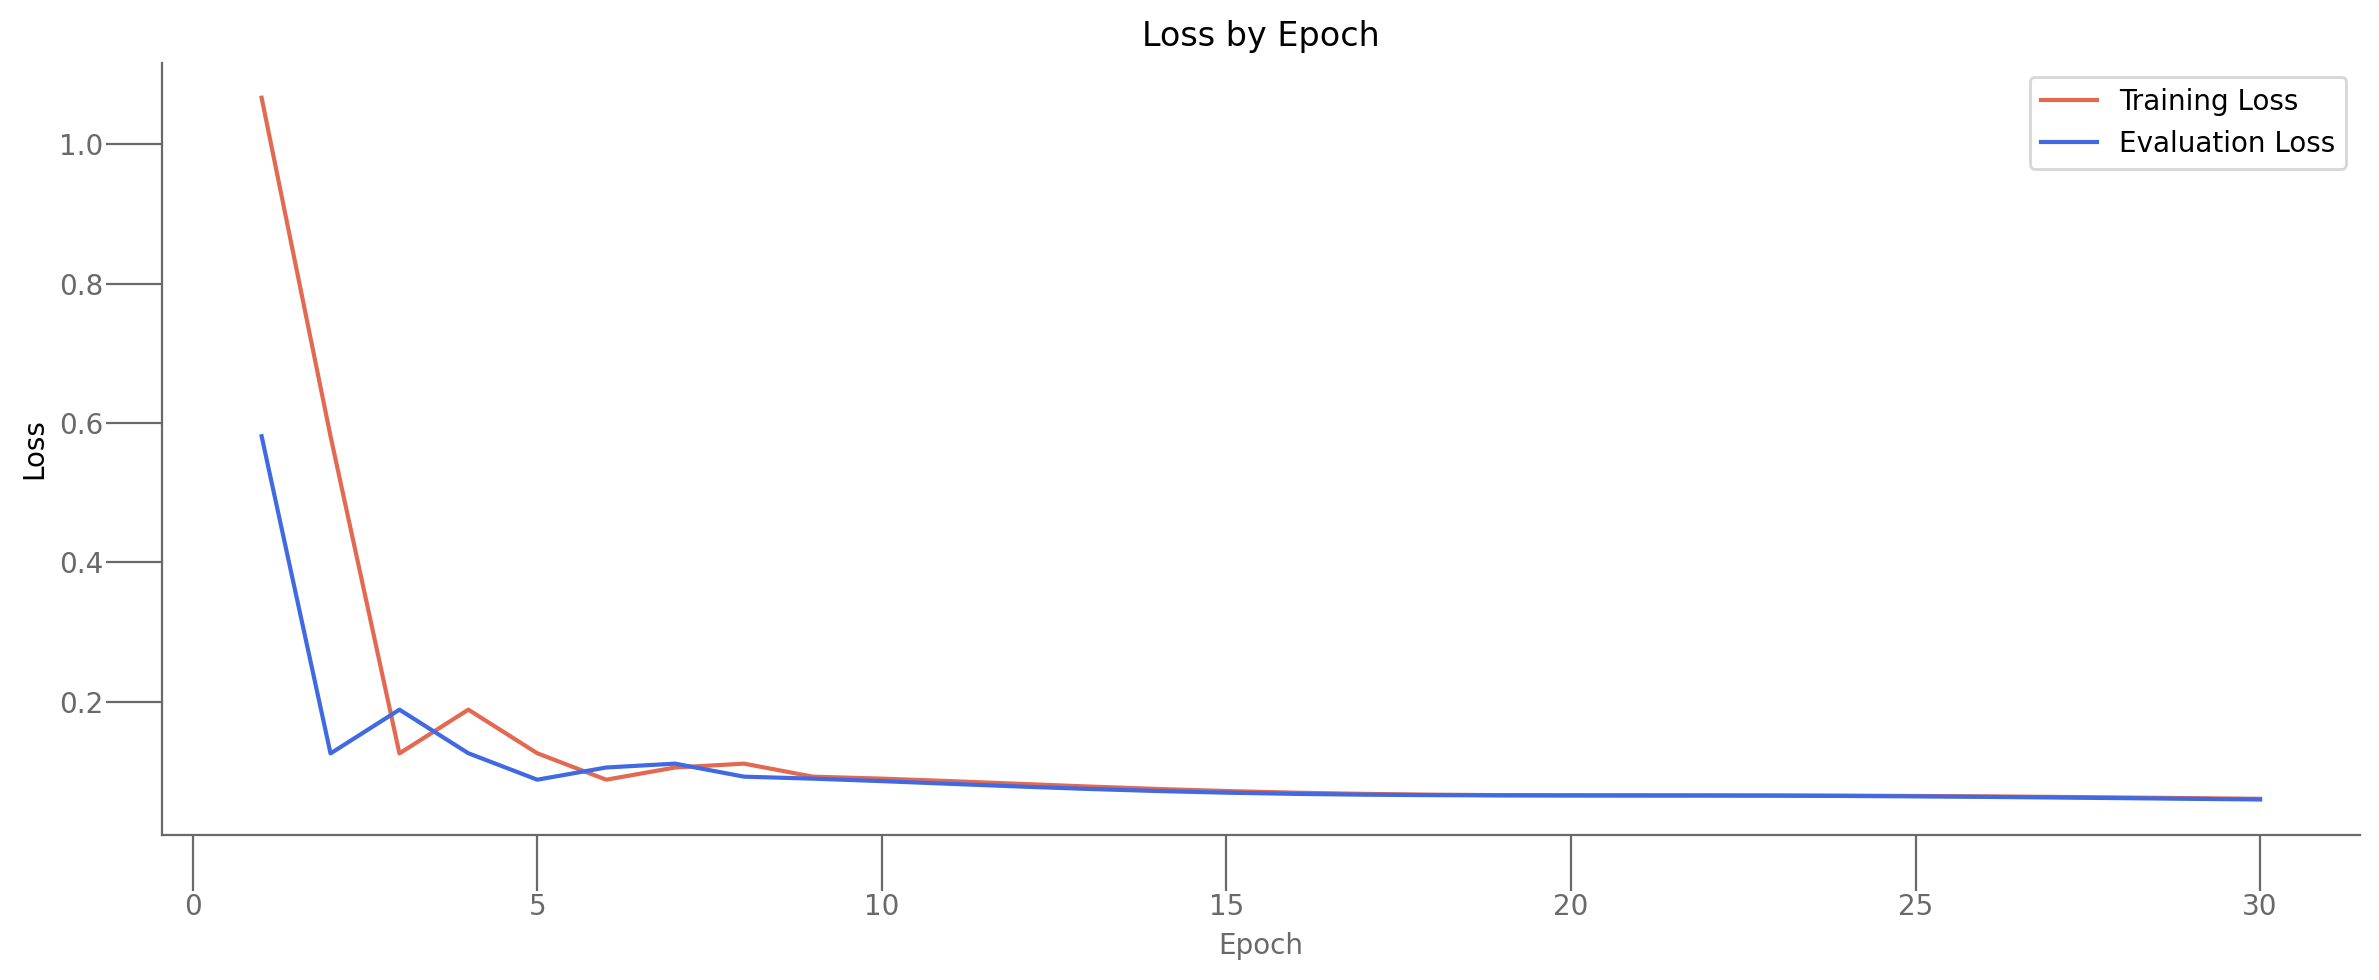


==================== TEST INFO ===================

Test_loss:0.0598, Test_r2:-13.6372


In [13]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
        }
dataloader = trainer.train_test_val_split(dataset_gt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


num_early_stop = 0
num_epochs = 30
lr = 0.01

model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")

losses,eval_losses, r2scores, h = train(model, dataloader, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions, real = test(model, dataloader, h)


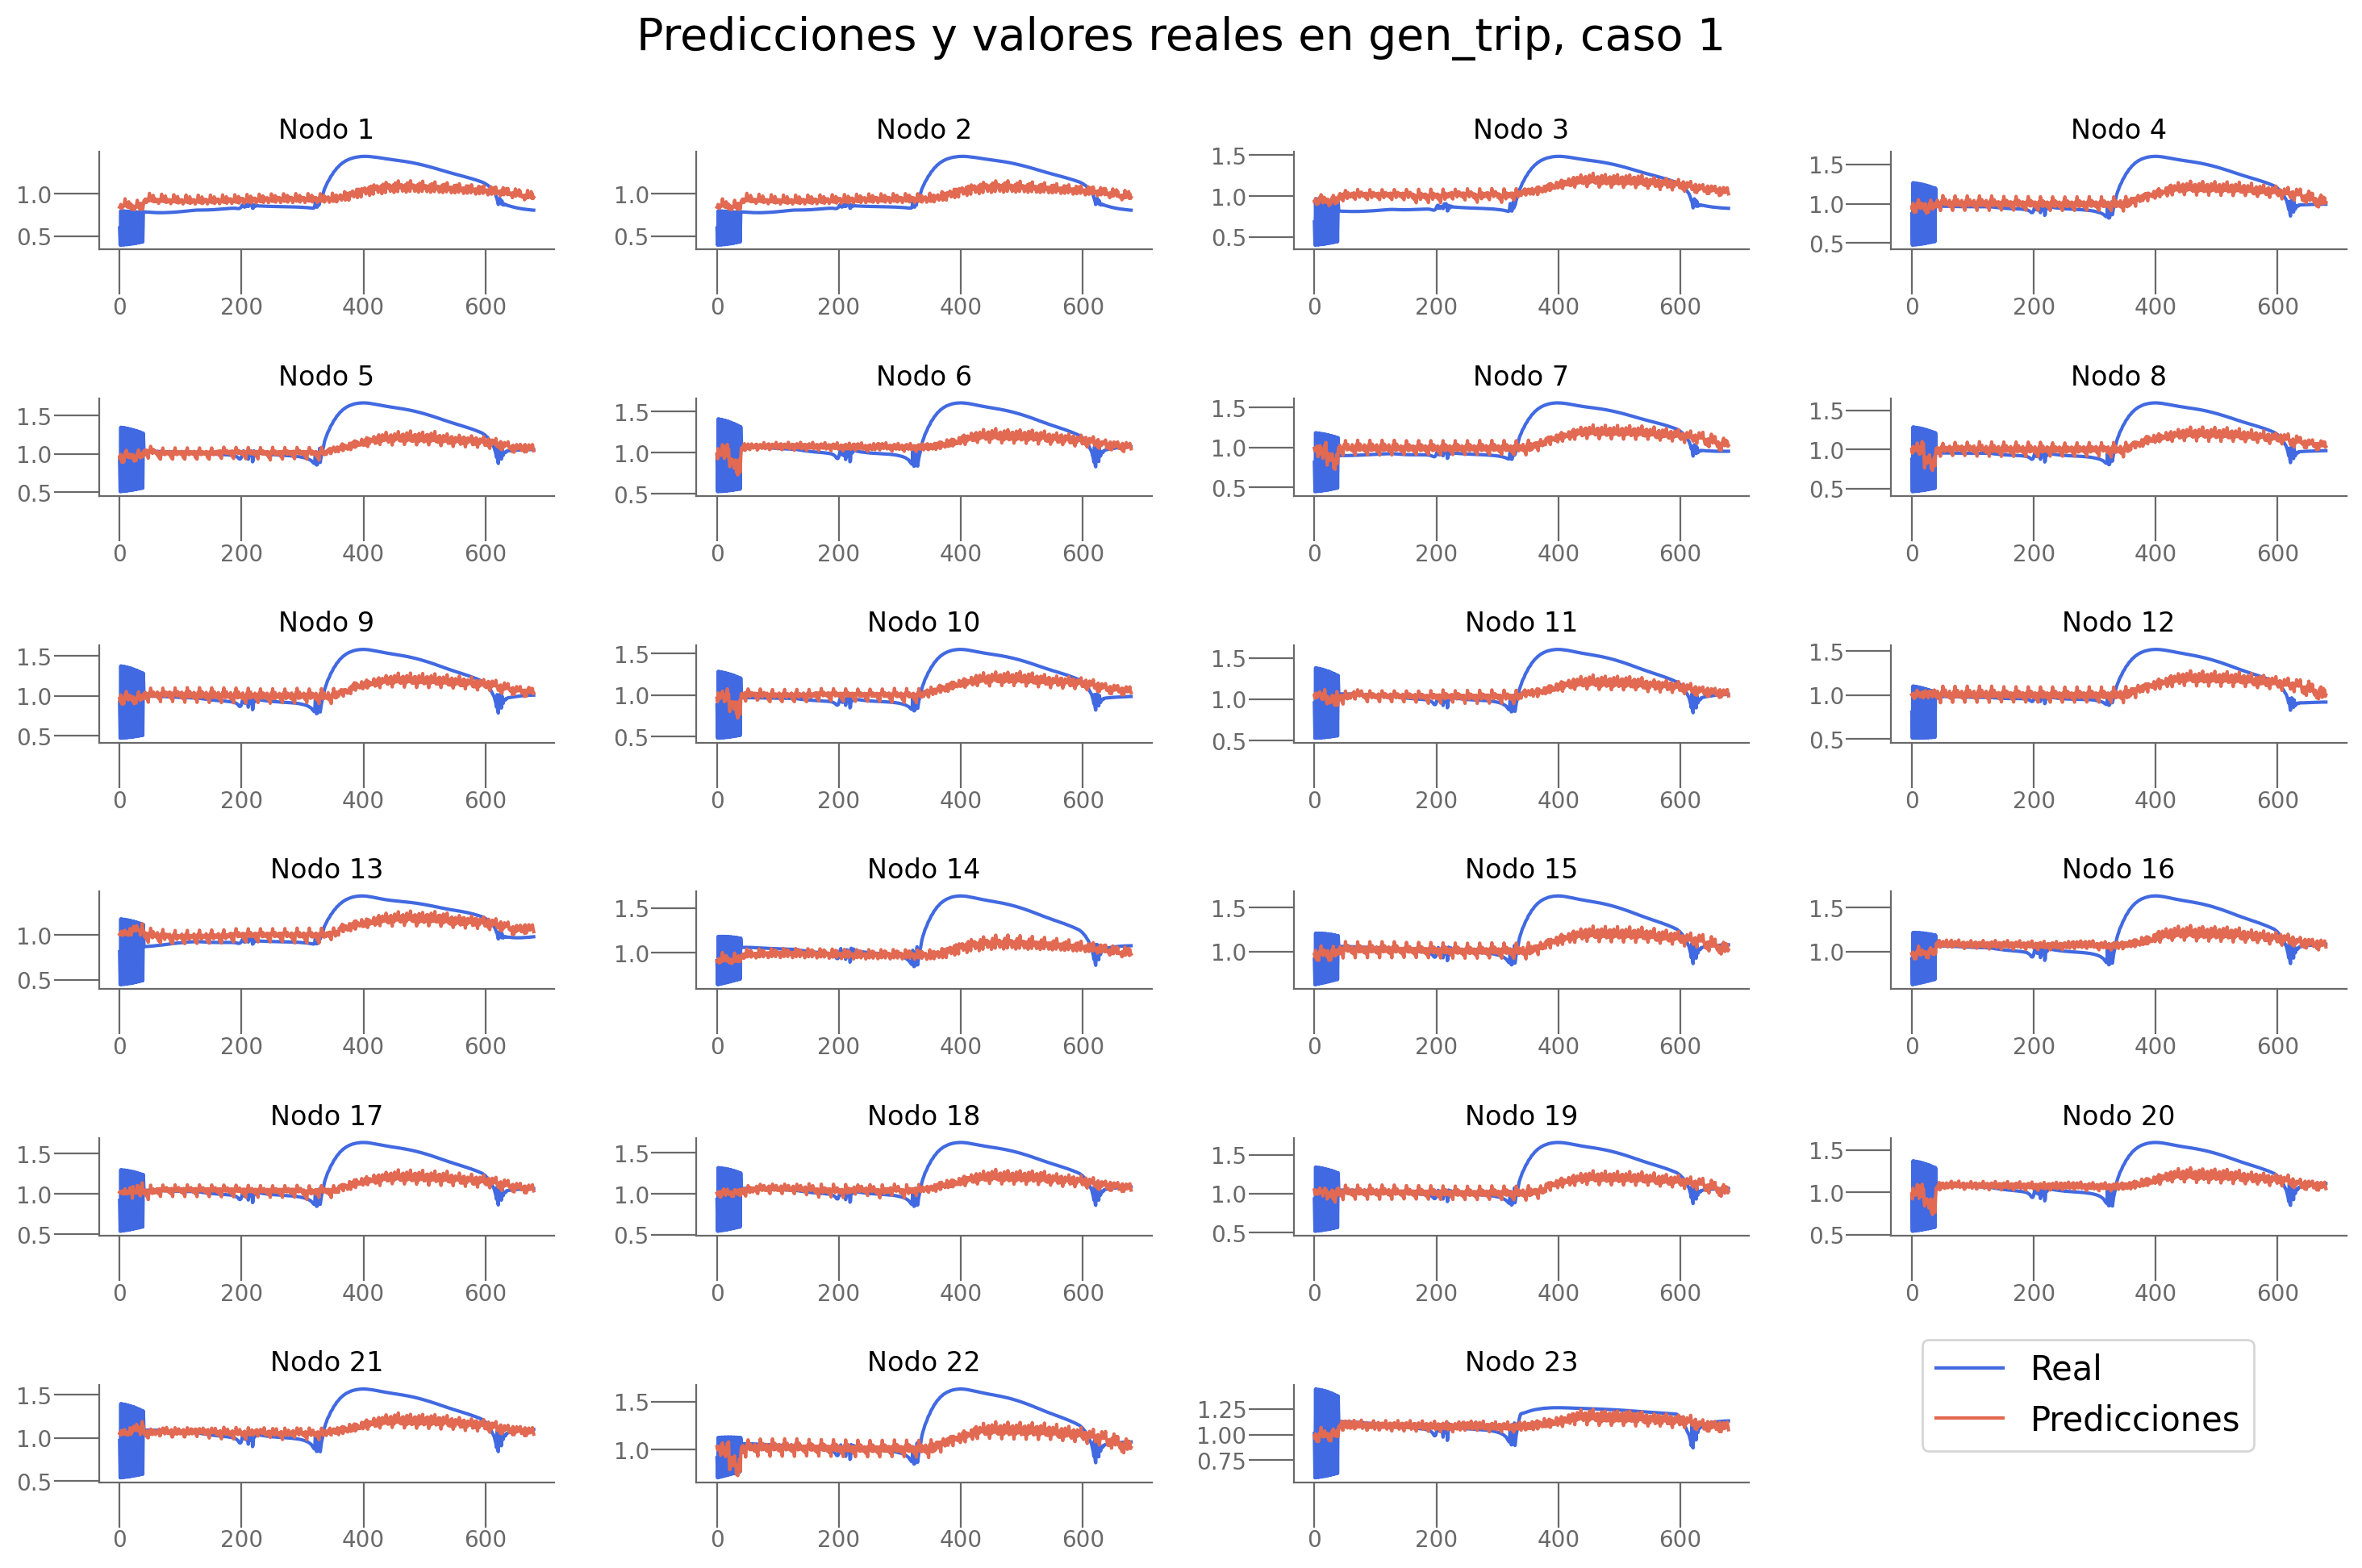

In [14]:
plot_predictions(predictions, real, n_target, 1, n_div_gt, problem)

### Bus trip

In [15]:
problem = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [16]:
n_div_bt = loader.div

#### Sencilla 

In [17]:
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9332 | Eval Loss: 0.4658 | Eval R2: -13.1604 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4658 | Eval Loss: 0.1137 | Eval R2: -2.2192 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1137 | Eval Loss: 0.1487 | Eval R2: -3.9488 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1487 | Eval Loss: 0.0950 | Eval R2: -2.0260 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0950 | Eval Loss: 0.0684 | Eval R2: -0.8710 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0684 | Eval Loss: 0.0757 | Eval R2: -0.9511 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0757 | Eval Loss: 0.0753 | Eval R2: -0.9283 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0753 | Eval Loss: 0.0599 | Eval R2: -0.5372 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0599 | Eval Loss: 0.0462 | Eval R2: -0.2556 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0462 | Eval Loss: 0.0445 

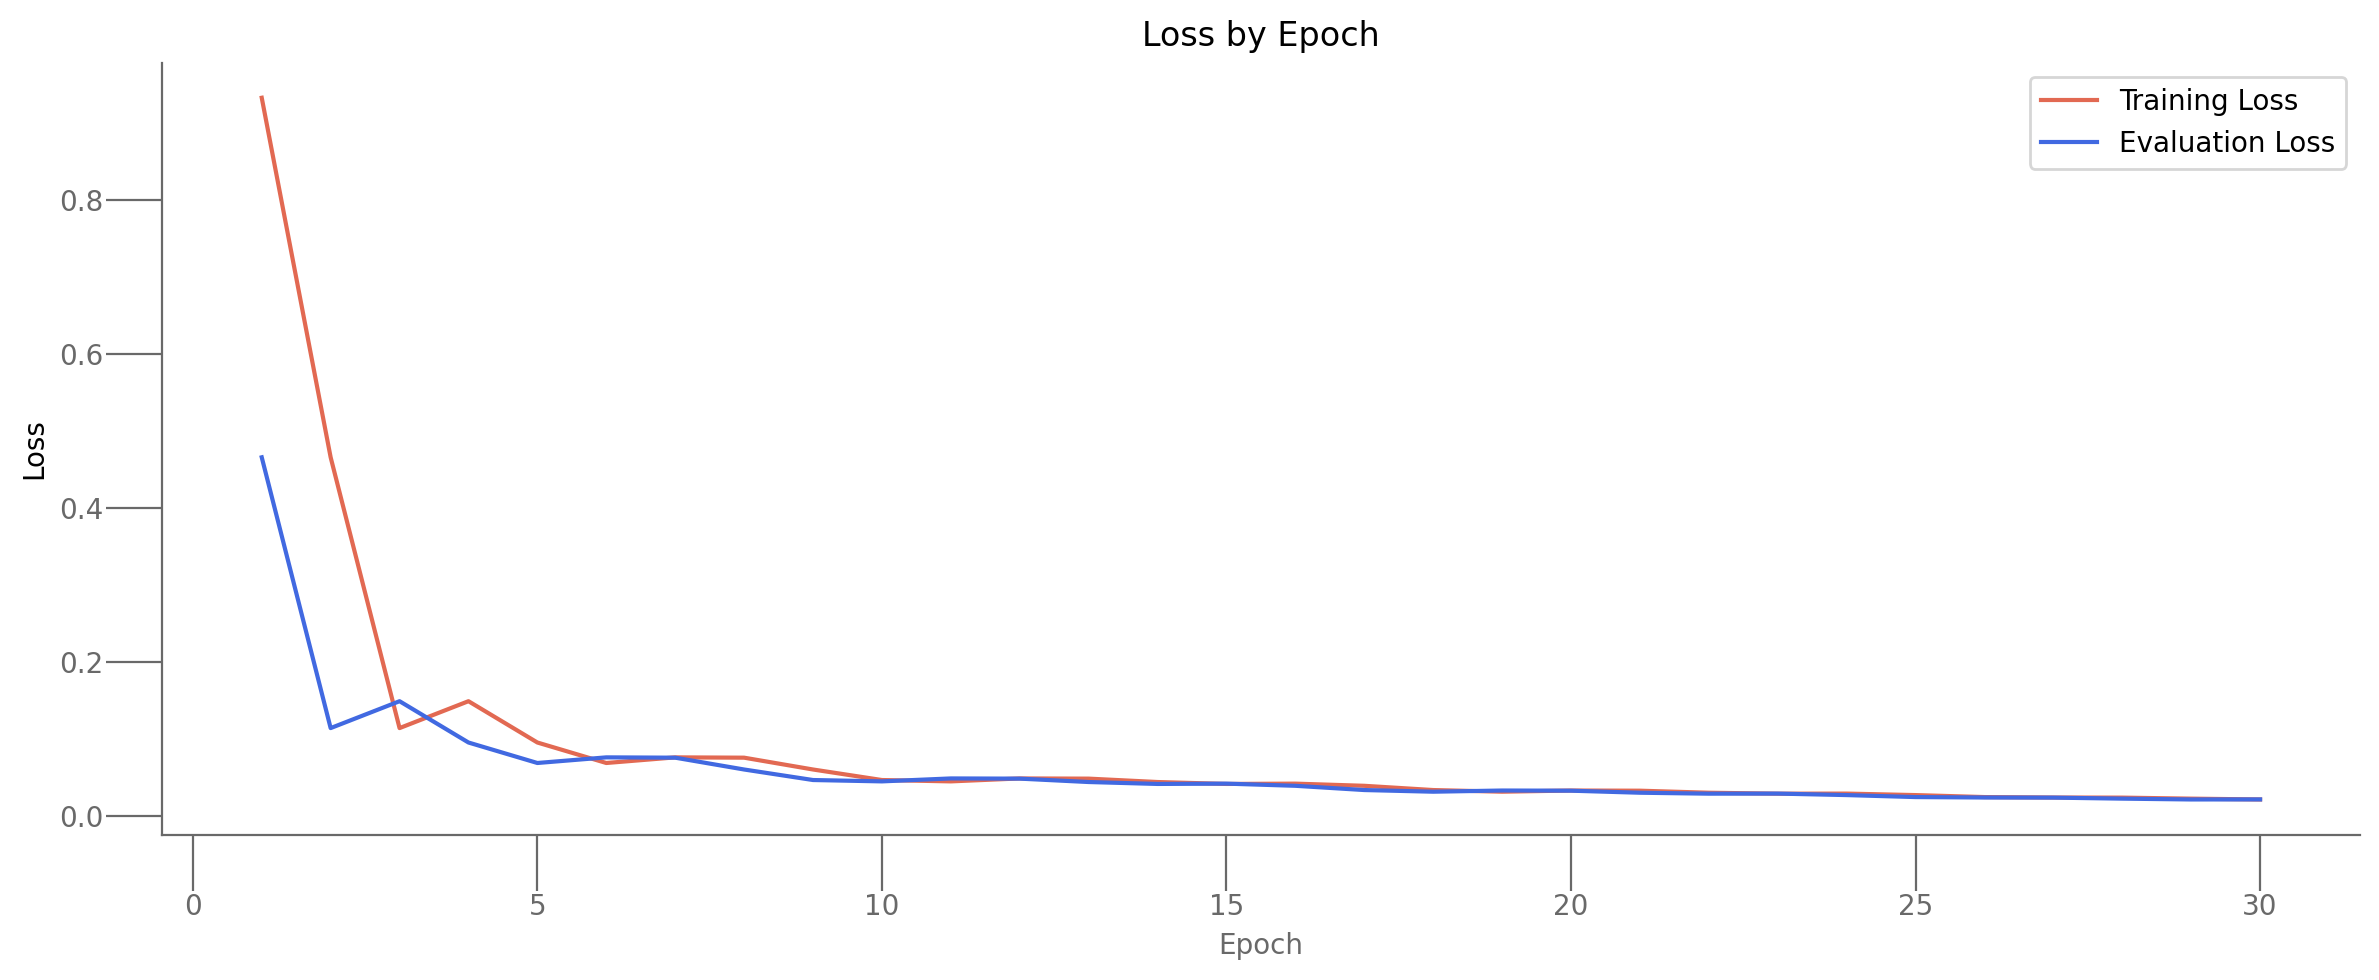


==================== TEST INFO ===================

Test_loss:0.0210, Test_r2:0.4344


In [18]:

dataloader_bt = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_bt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01


losses,eval_losses, r2scores, h = train(model_bt, dataloader_bt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_bt, real_bt = test(model_bt, dataloader_bt, h)


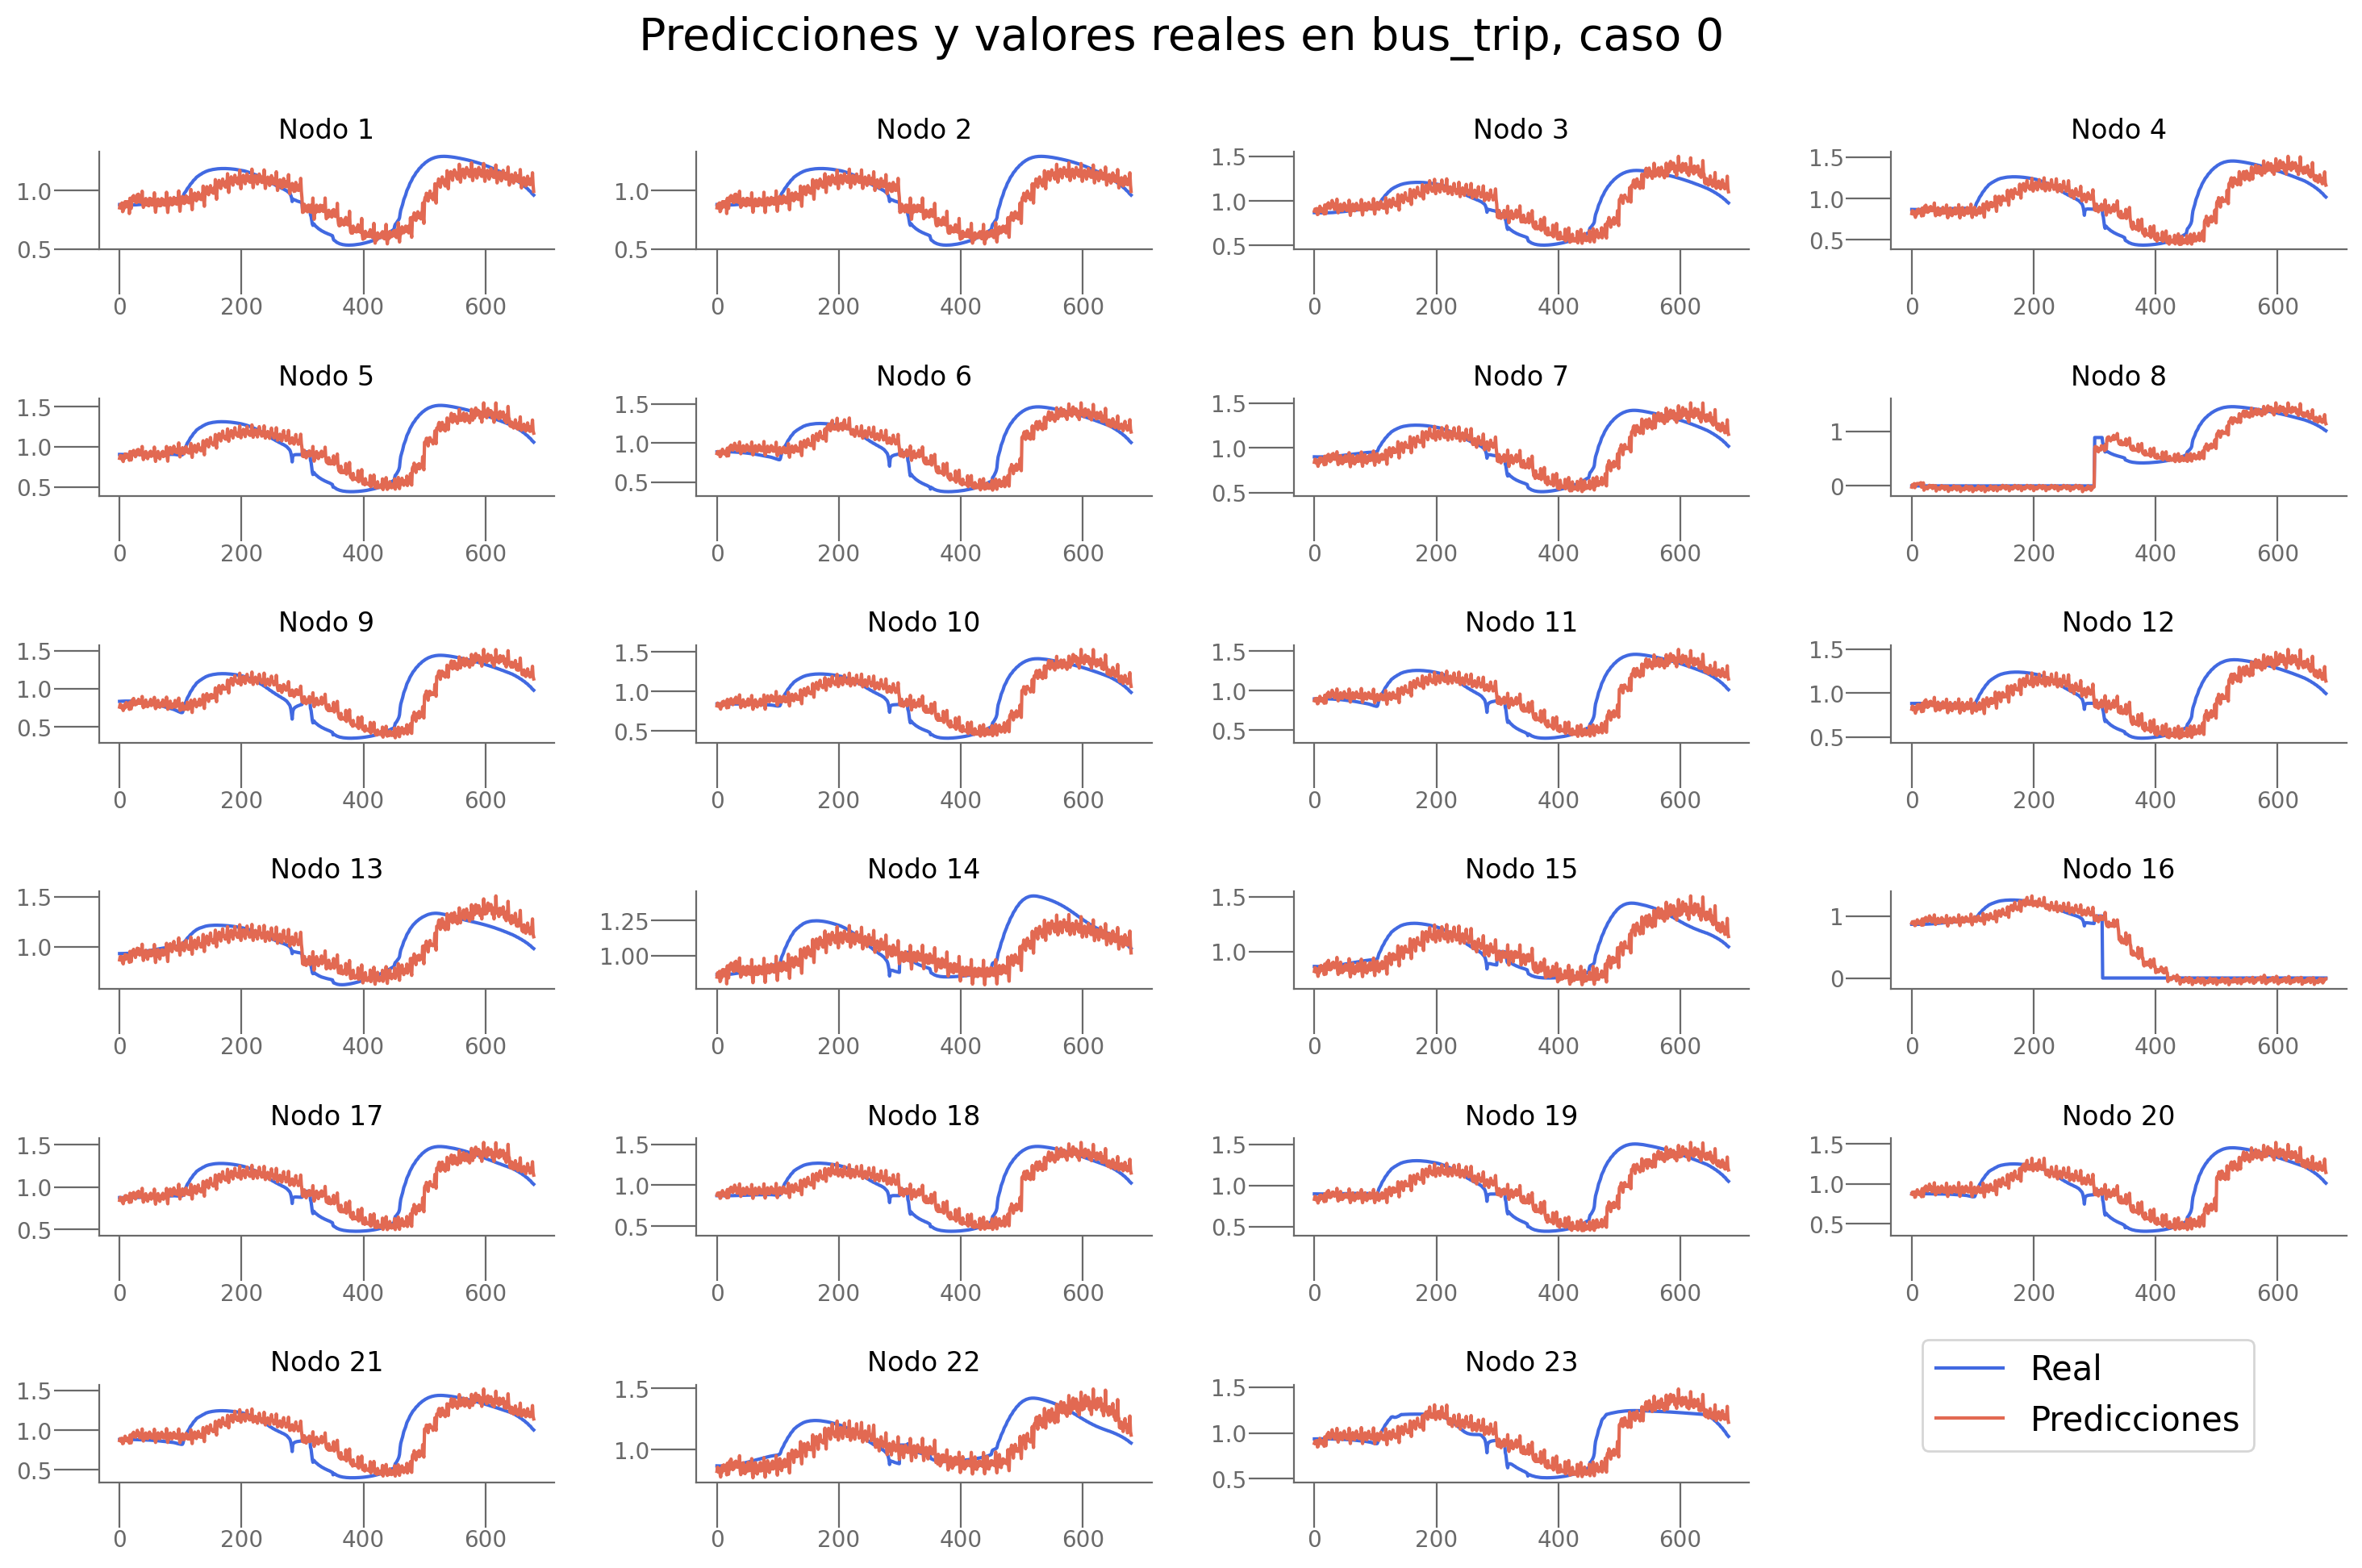

In [19]:
plot_predictions(predictions_bt, real_bt, n_target, 0, n_div_bt, problem)

### Bus fault

In [20]:
problem = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [21]:
n_div_bf = loader.div

#### Sencilla 

In [22]:
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9332 | Eval Loss: 0.4658 | Eval R2: -13.1604 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4658 | Eval Loss: 0.1137 | Eval R2: -2.2192 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1137 | Eval Loss: 0.1487 | Eval R2: -3.9488 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1487 | Eval Loss: 0.0950 | Eval R2: -2.0260 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0950 | Eval Loss: 0.0684 | Eval R2: -0.8710 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0684 | Eval Loss: 0.0757 | Eval R2: -0.9511 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0757 | Eval Loss: 0.0753 | Eval R2: -0.9283 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0753 | Eval Loss: 0.0599 | Eval R2: -0.5372 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0599 | Eval Loss: 0.0462 | Eval R2: -0.2556 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0462 | Eval Loss: 0.0445 

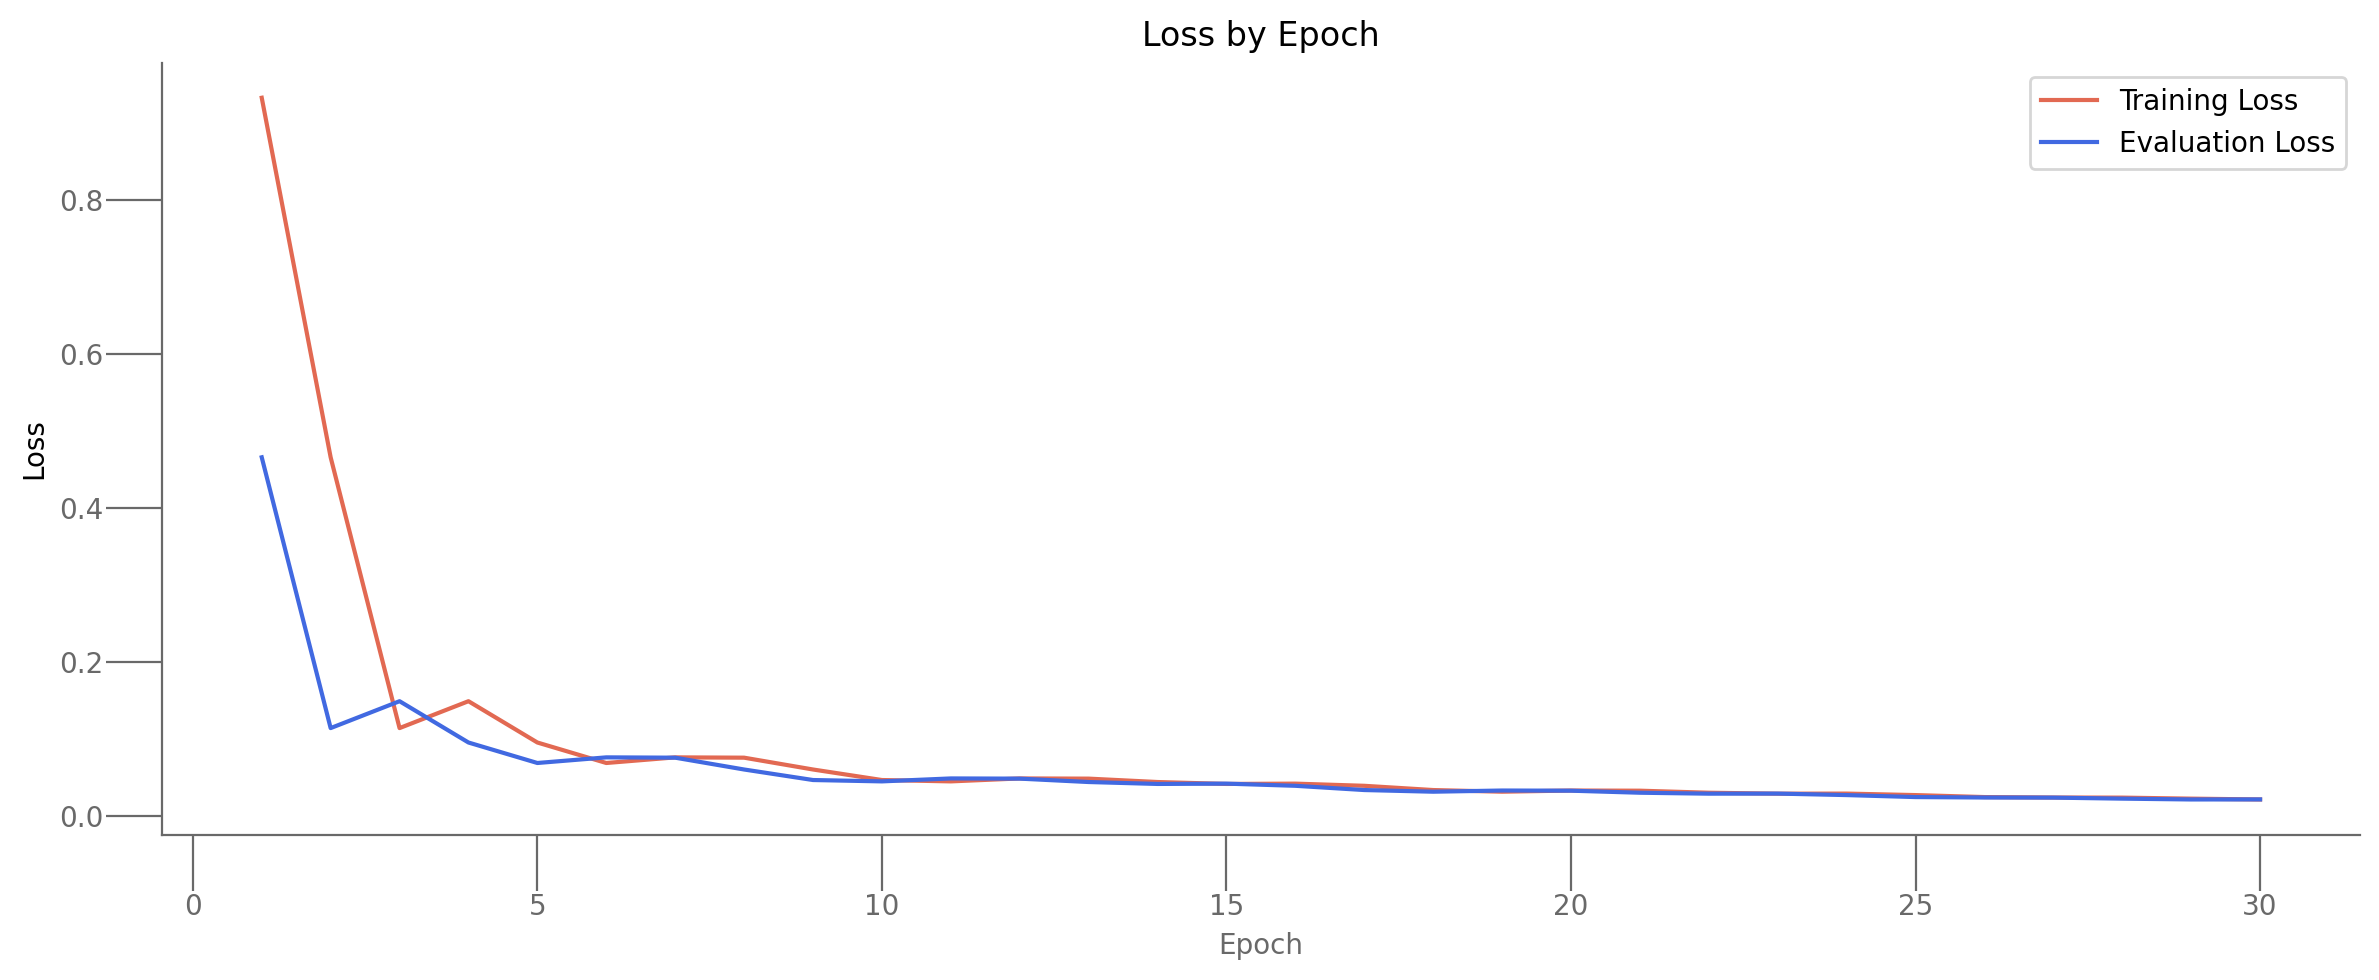


==================== TEST INFO ===================

Test_loss:0.0210, Test_r2:0.4344


In [23]:

dataloader_bf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_bf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_bf, dataloader_bf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_bf, real_bf = test(model_bf, dataloader_bf, h)


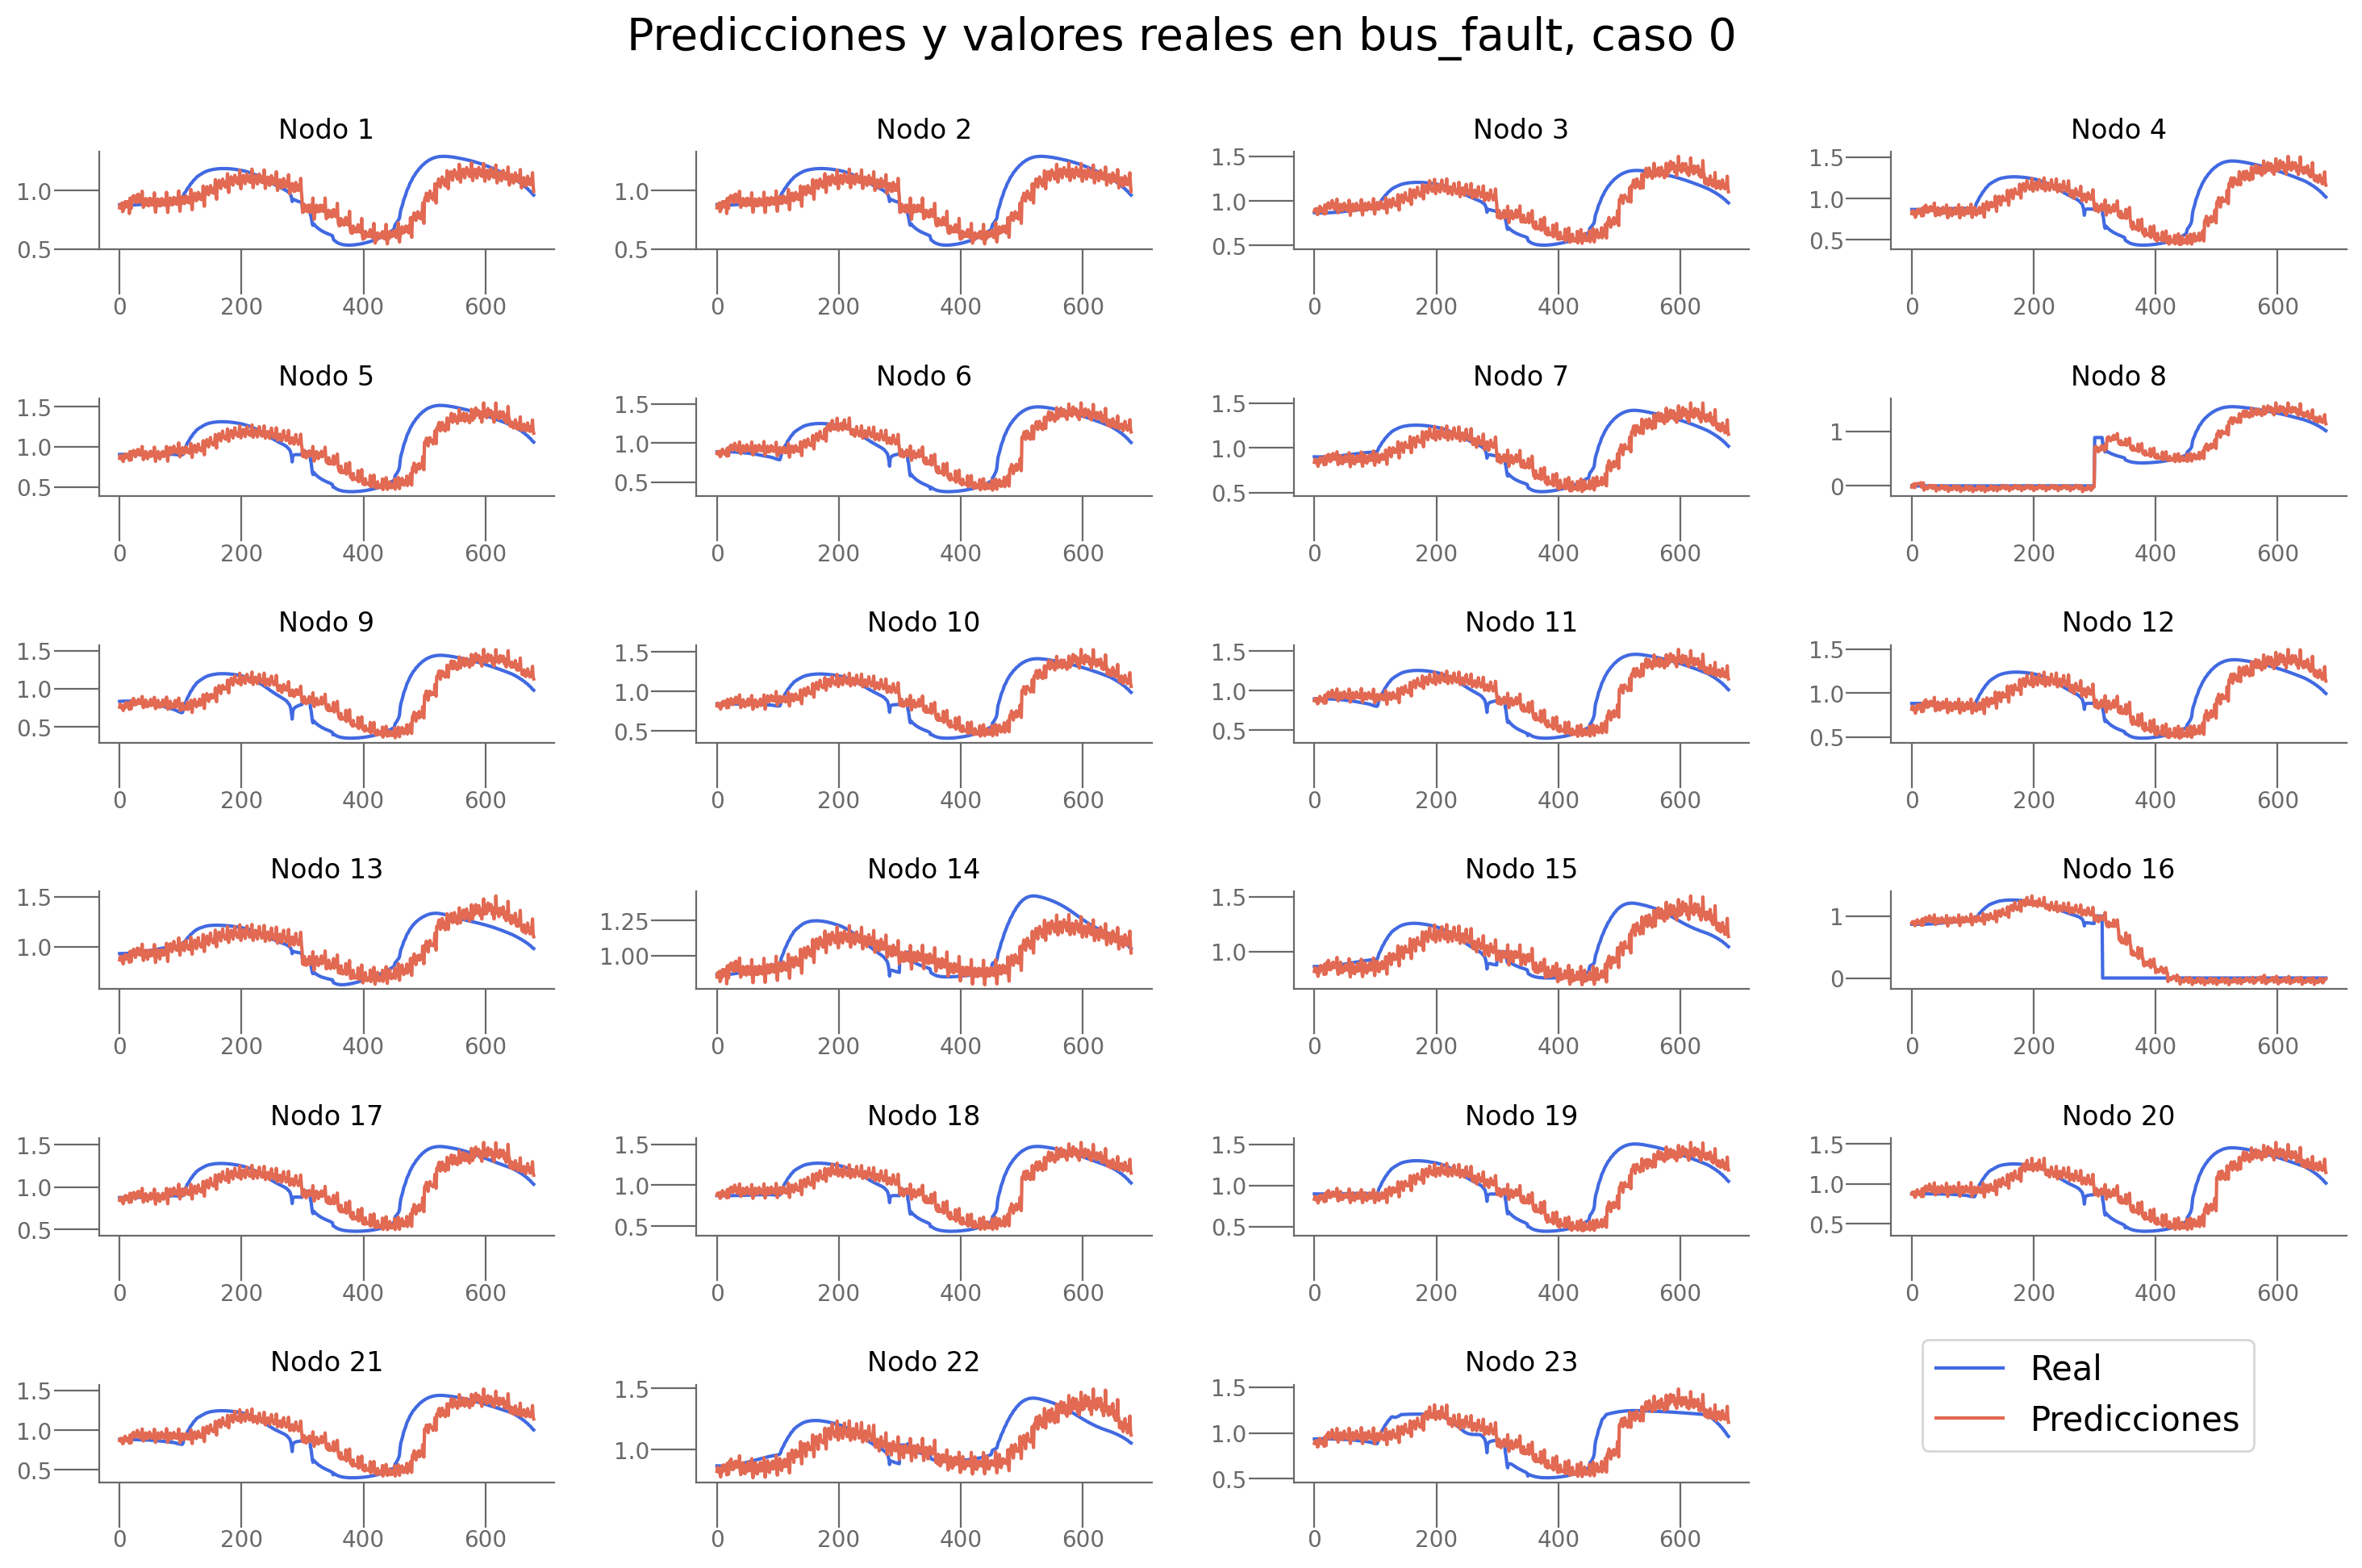

In [24]:
plot_predictions(predictions_bf, real_bf, n_target, 0,n_div_bf, problem)

### Branch Fault

In [25]:
problem = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [26]:
n_div_brf = loader.div

#### Sencilla 

In [27]:
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9332 | Eval Loss: 0.4658 | Eval R2: -13.1604 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4658 | Eval Loss: 0.1137 | Eval R2: -2.2192 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1137 | Eval Loss: 0.1487 | Eval R2: -3.9488 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1487 | Eval Loss: 0.0950 | Eval R2: -2.0260 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0950 | Eval Loss: 0.0684 | Eval R2: -0.8710 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0684 | Eval Loss: 0.0757 | Eval R2: -0.9511 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0757 | Eval Loss: 0.0753 | Eval R2: -0.9283 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0753 | Eval Loss: 0.0599 | Eval R2: -0.5372 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0599 | Eval Loss: 0.0462 | Eval R2: -0.2556 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0462 | Eval Loss: 0.0445 

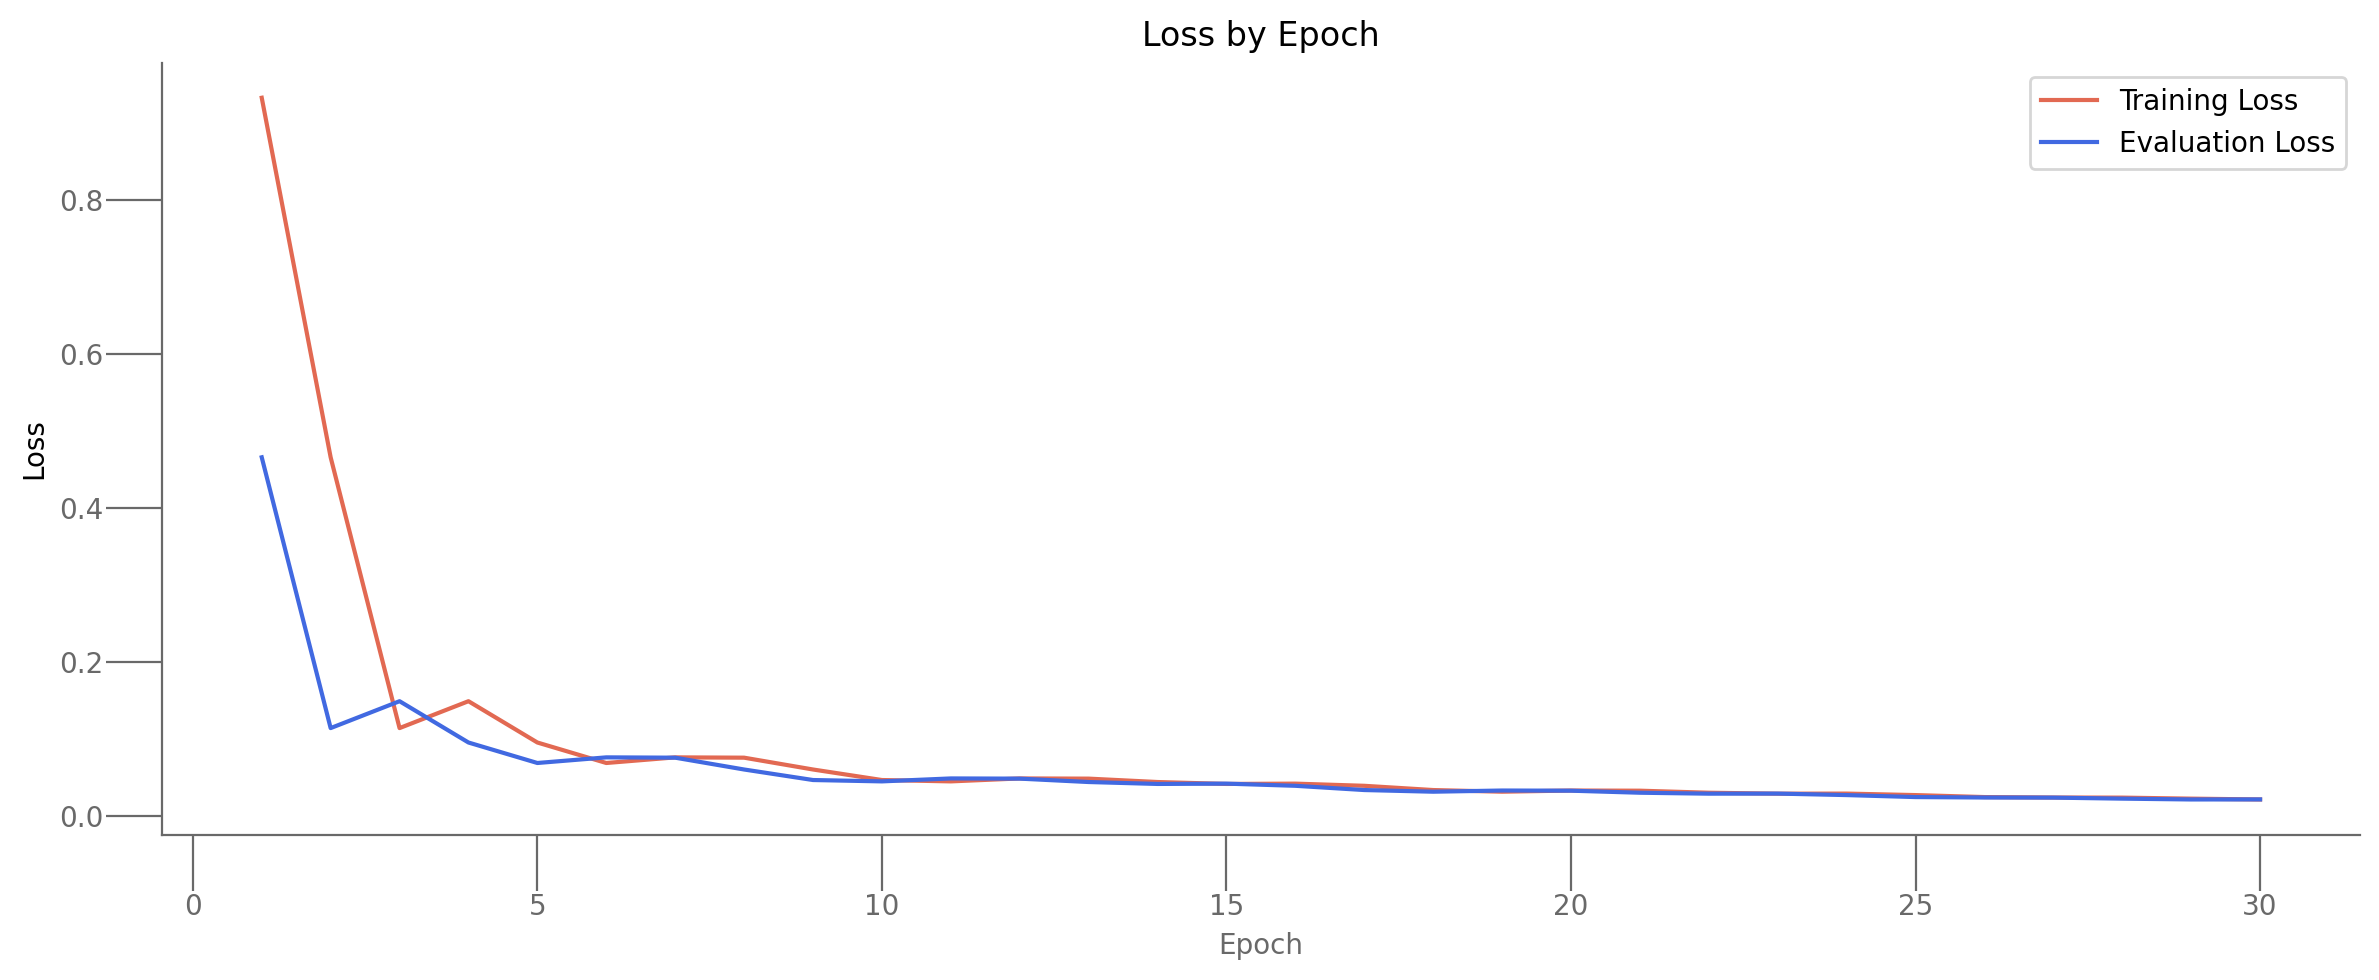


==================== TEST INFO ===================

Test_loss:0.0210, Test_r2:0.4344


In [28]:
dataloader_brf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_brf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brf, dataloader_brf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_brf, real_brf = test(model_brf, dataloader_brf, h)


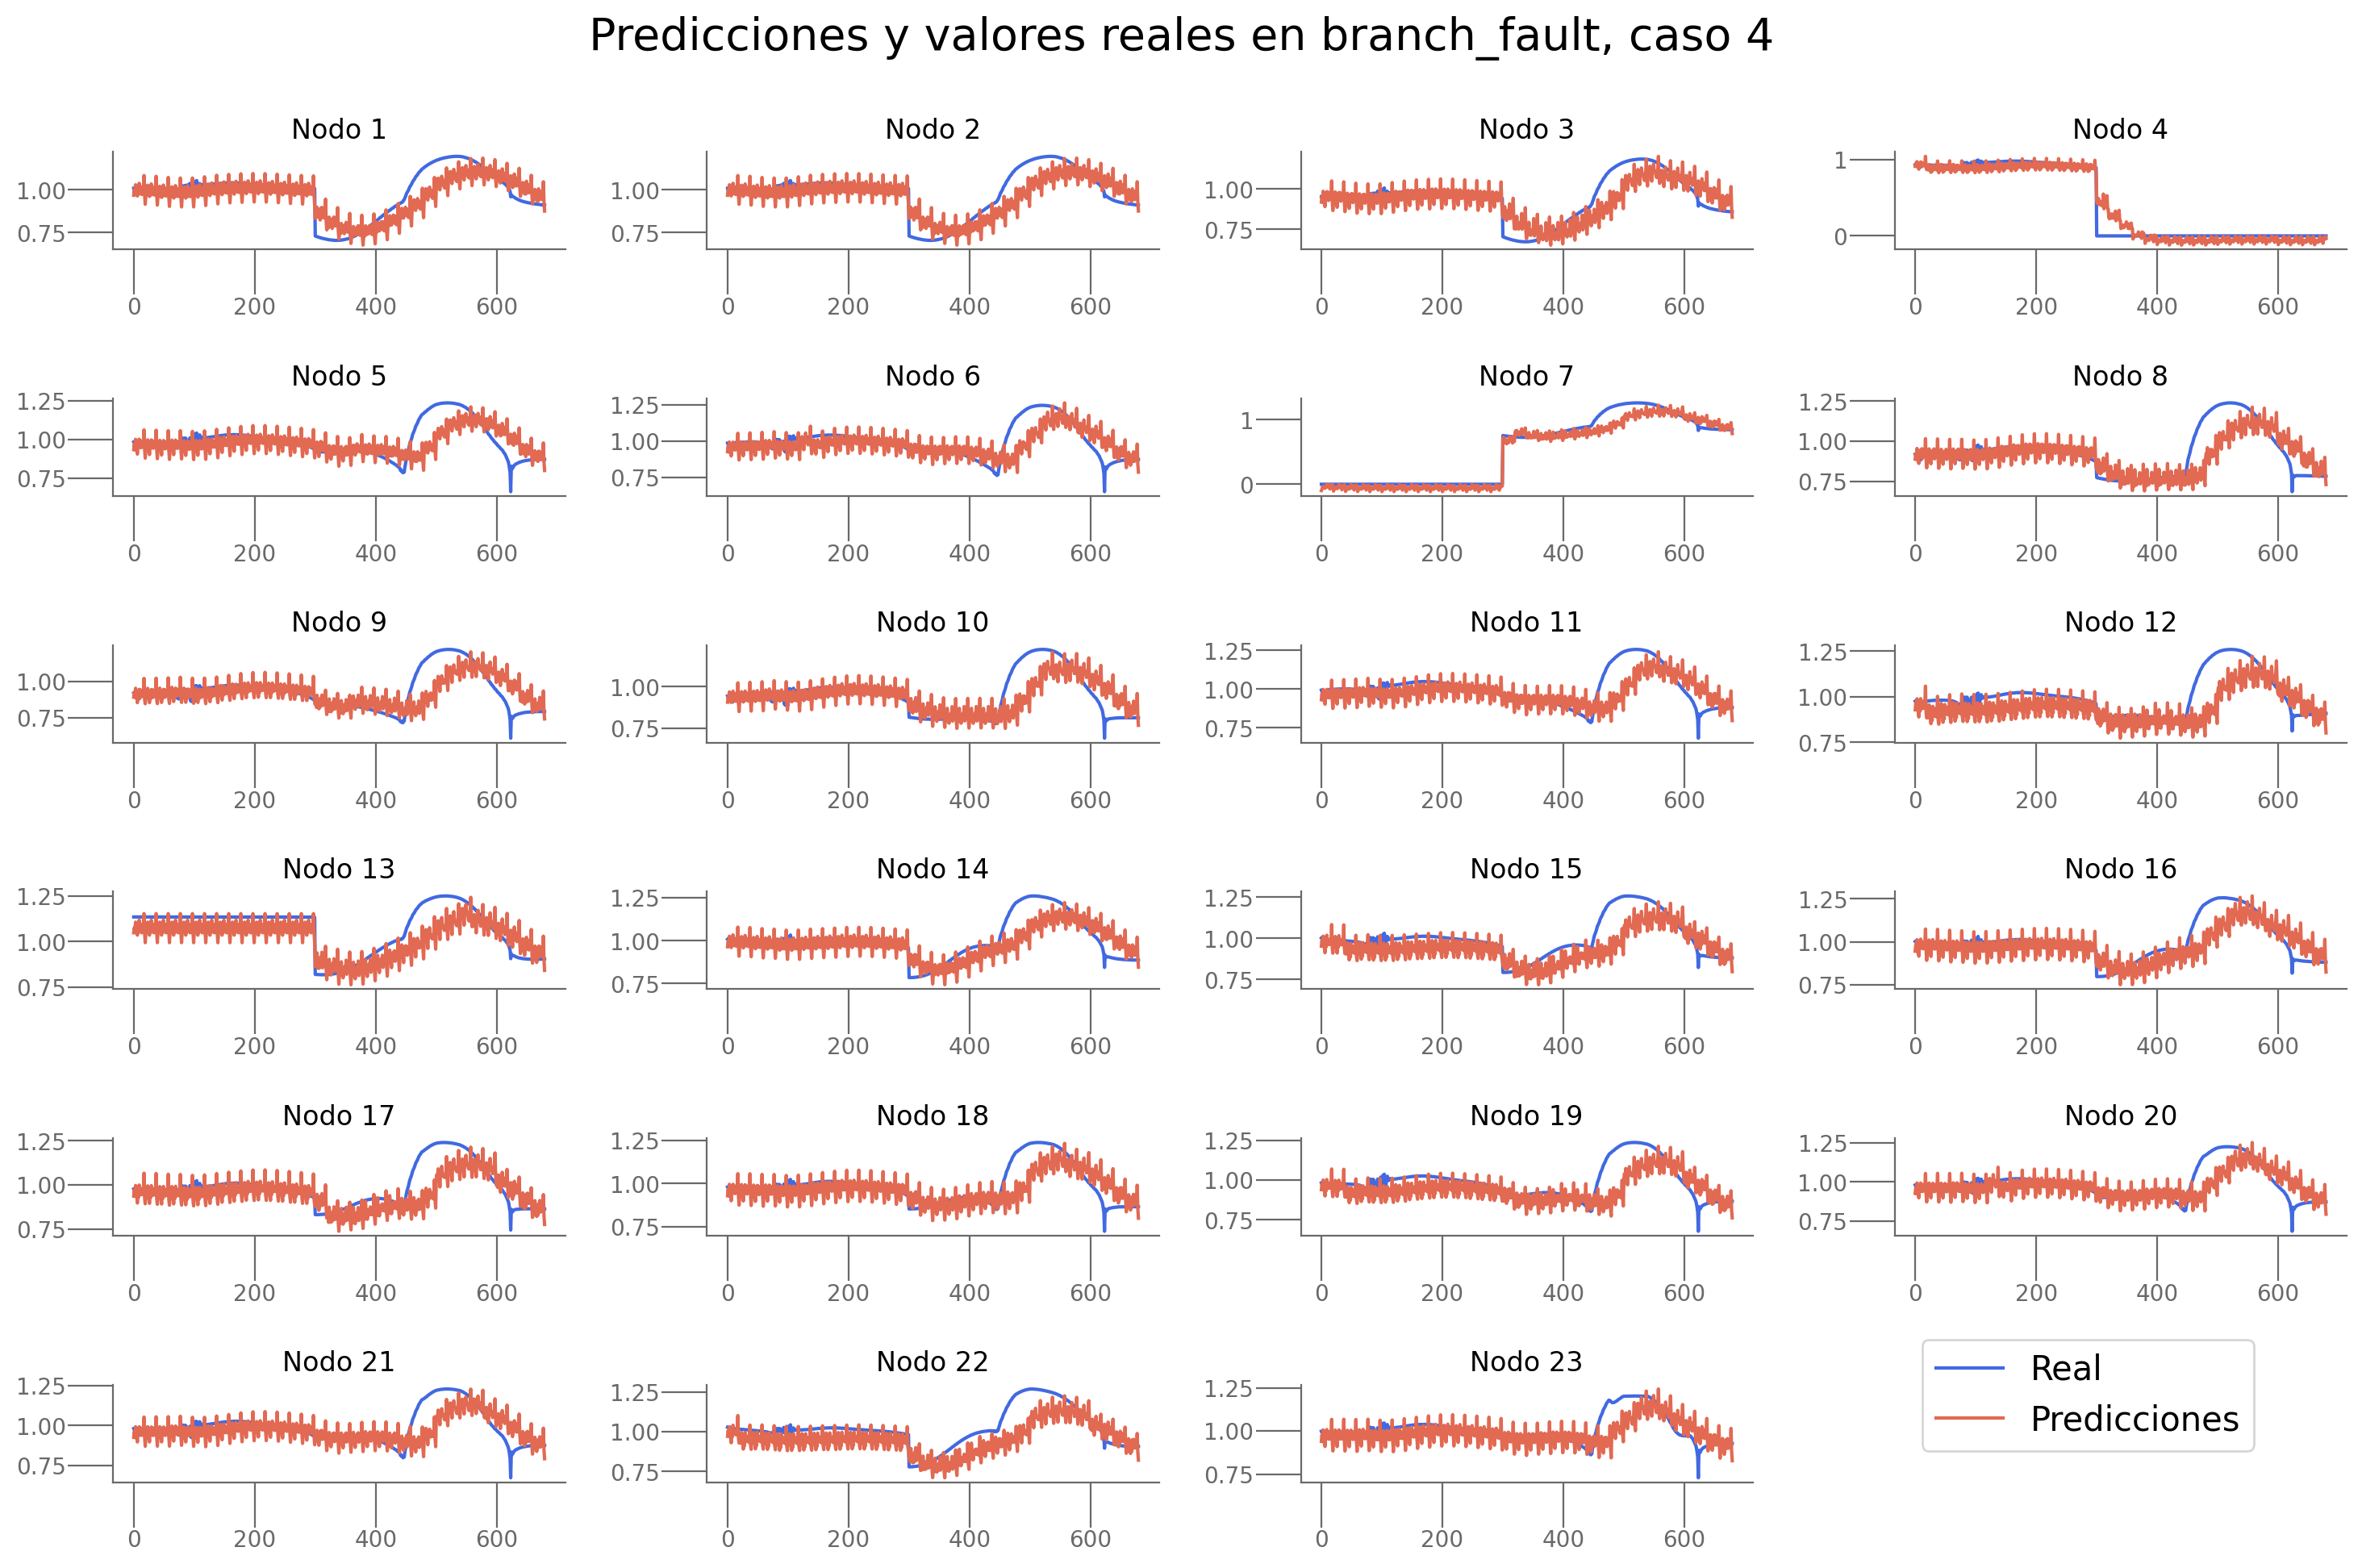

In [29]:
plot_predictions(predictions_brf, real_brf, n_target, 4,  n_div_brf, problem)

### Branch trip

In [30]:
problem = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [31]:
n_div_brt = loader.div

#### Sencilla 

In [32]:
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9332 | Eval Loss: 0.4658 | Eval R2: -13.1604 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4658 | Eval Loss: 0.1137 | Eval R2: -2.2192 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1137 | Eval Loss: 0.1487 | Eval R2: -3.9488 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1487 | Eval Loss: 0.0950 | Eval R2: -2.0260 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0950 | Eval Loss: 0.0684 | Eval R2: -0.8710 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0684 | Eval Loss: 0.0757 | Eval R2: -0.9511 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0757 | Eval Loss: 0.0753 | Eval R2: -0.9283 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0753 | Eval Loss: 0.0599 | Eval R2: -0.5372 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0599 | Eval Loss: 0.0462 | Eval R2: -0.2556 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0462 | Eval Loss: 0.0445 

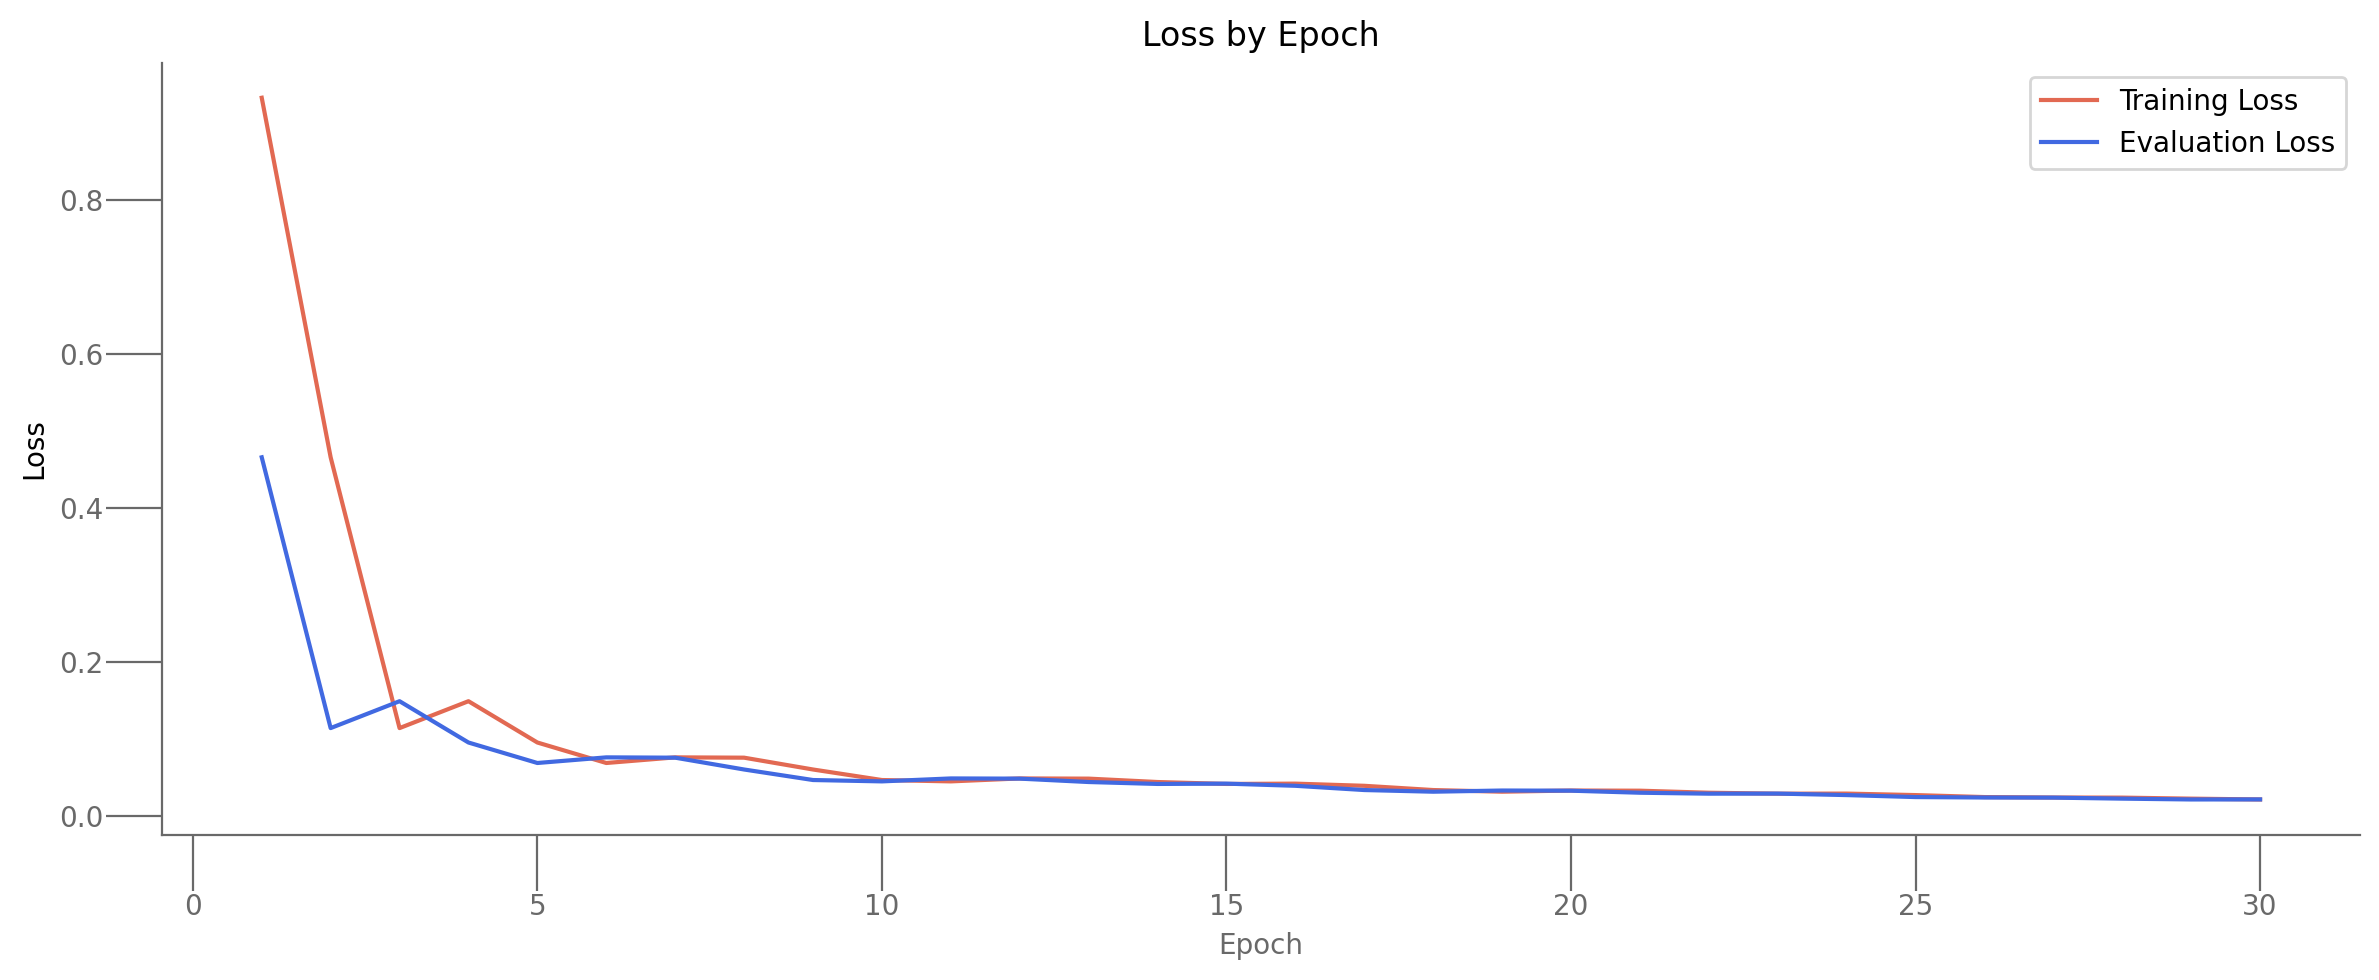


==================== TEST INFO ===================

Test_loss:0.0210, Test_r2:0.4344


In [33]:

dataloader_brt = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_brt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brt, dataloader_brt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_brt, real_brt = test(model_brt, dataloader_brt, h)


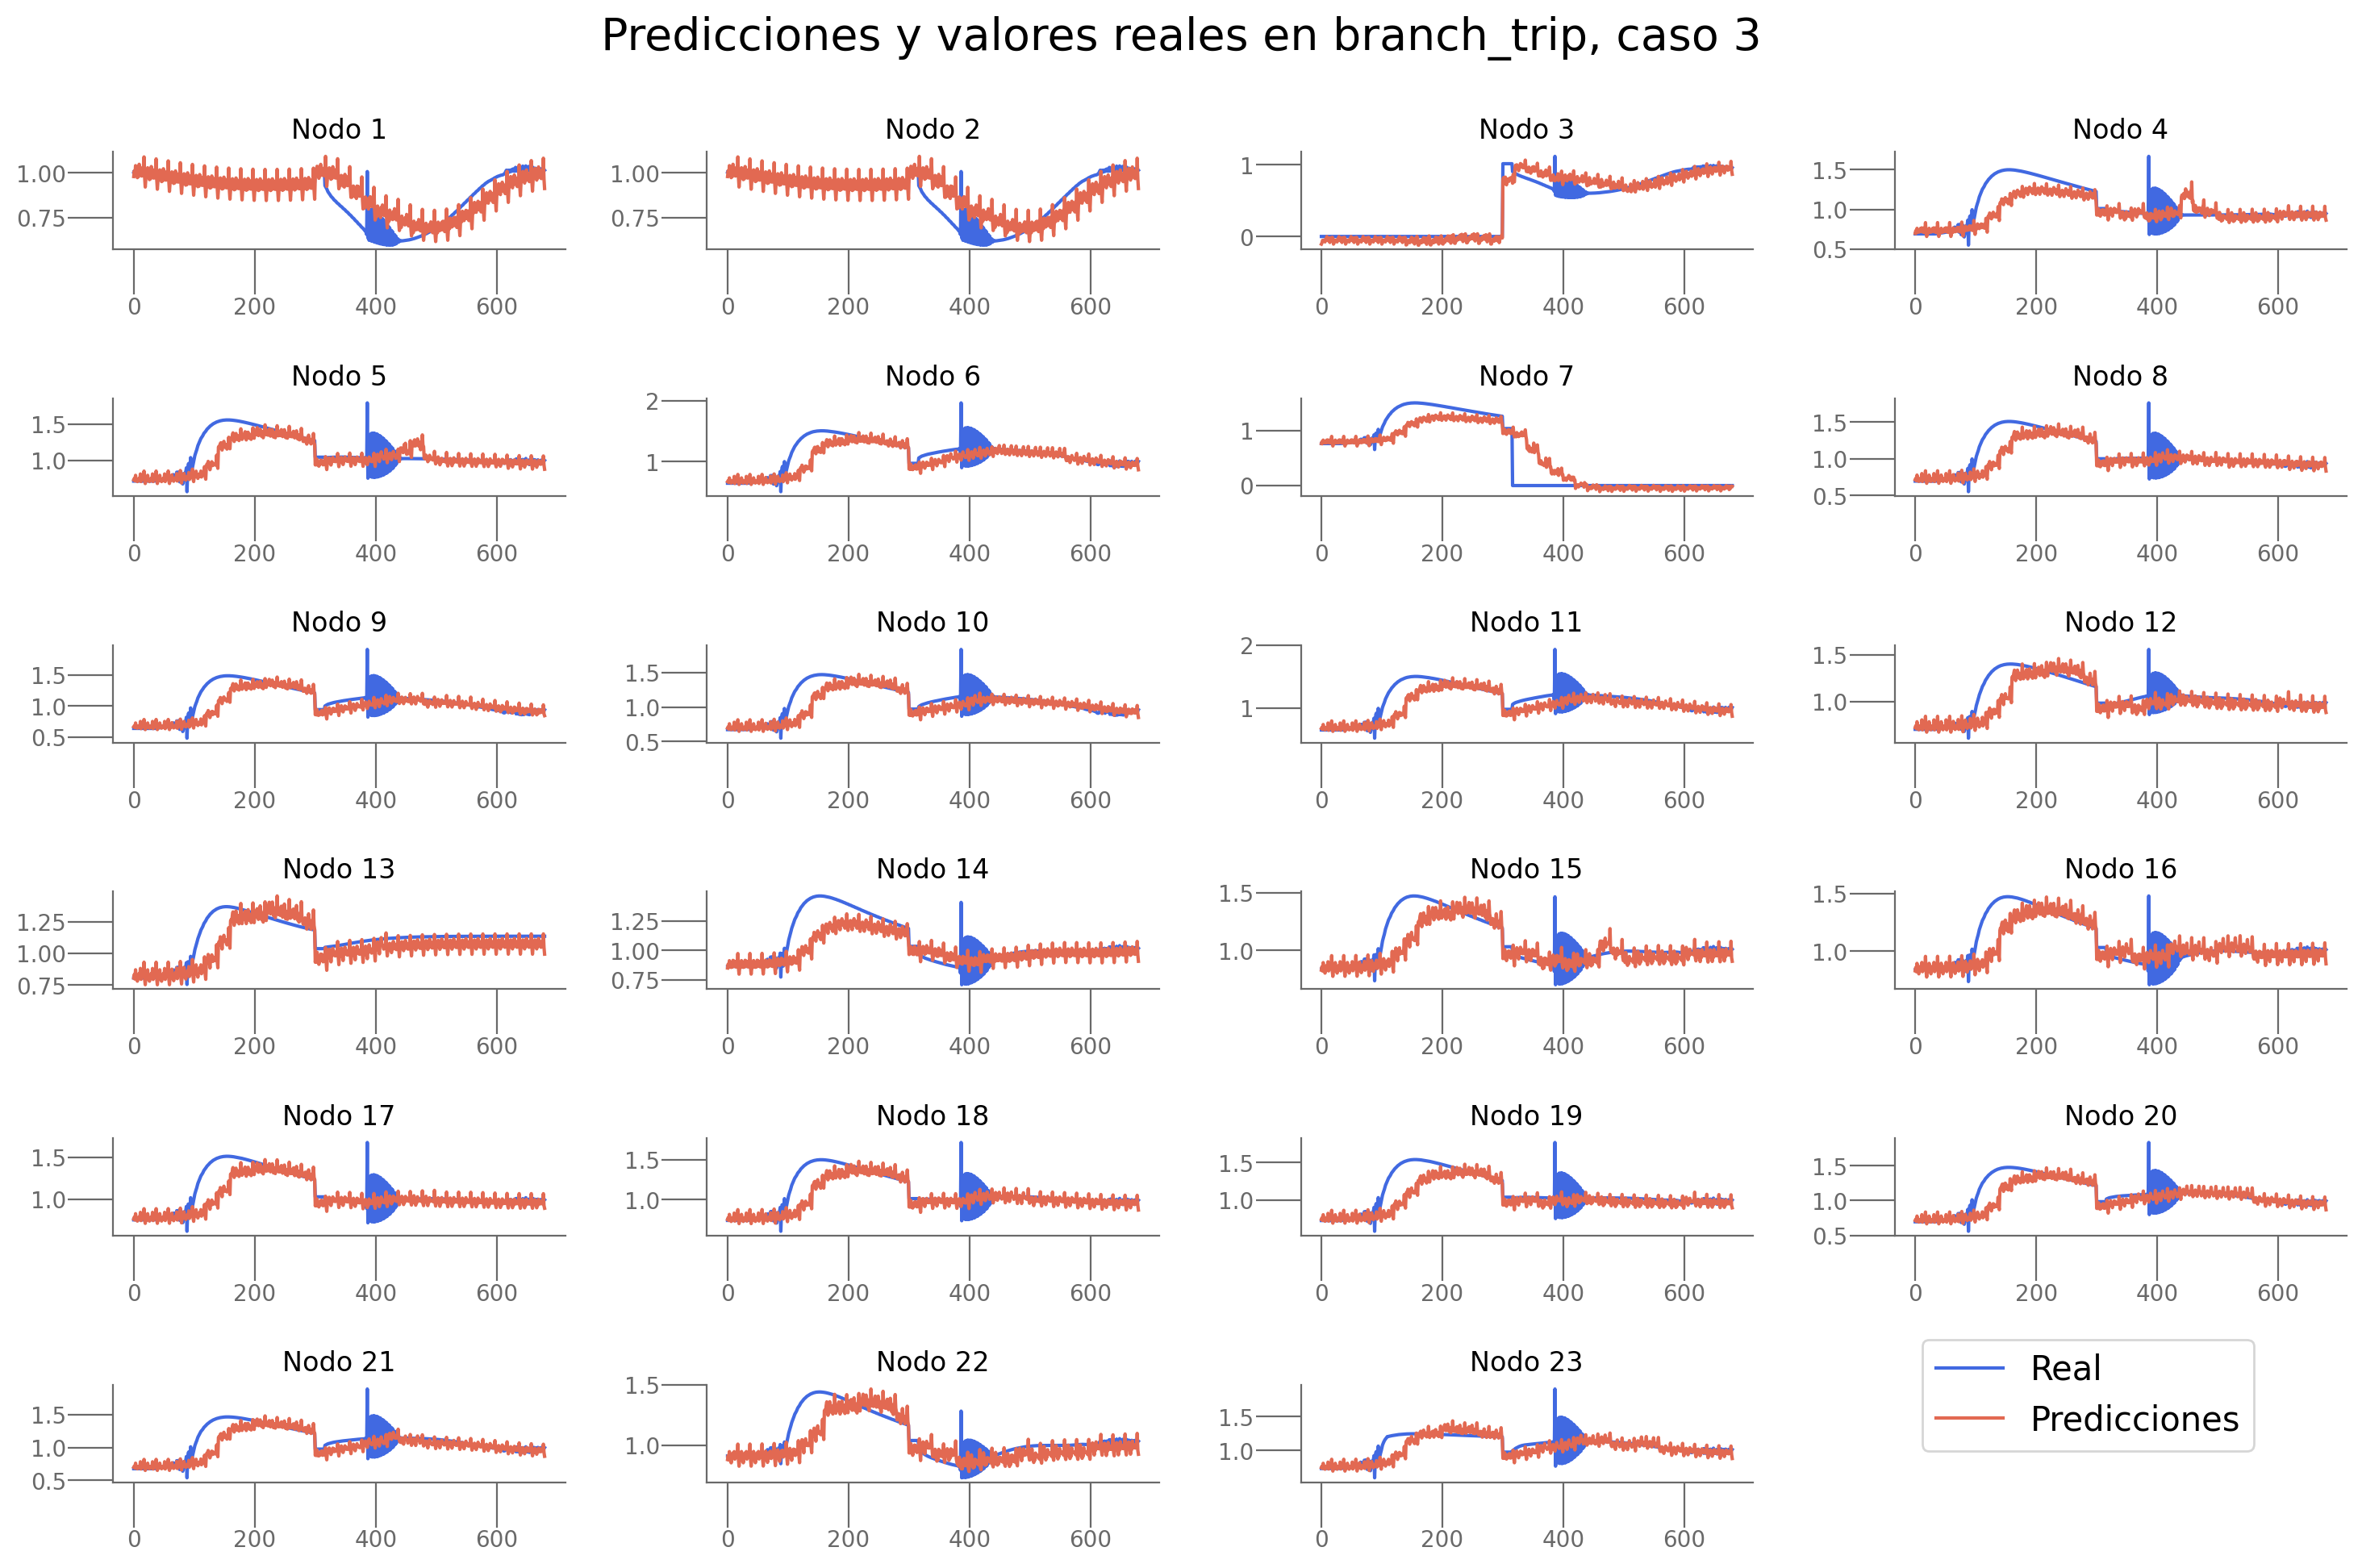

In [34]:
plot_predictions(predictions_brt, real_brt, n_target, 3, n_div_brt, problem)